# Cluster

## Objectives

* Fit and evaluate a cluster model to group similar data
* Understand the profile for each cluster


## Inputs
* outputs/datasets/collection/LoanDefaultData.csv
* Instructions on which variables to use for data cleaning and feature engineering. They are found in their respective notebooks.

## Outputs

* Cluster Pipeline
* Train Set
* Most important features to define a cluster plot
* Clusters Profile Description
* Cluster Silhouette


The objective of this notebook is to: fit a Cluster ML pipeline
that groups similar borrowers, and understands each cluster profile.
We will also analyze how Default levels are distributed across the Clusters.

It should be noted that we are now working with unsupervised learning
as opposed to previously when we were working with supervised learning.
Unsupervised Learning is slightly different due to one aspect:
there is no target variable. The algorithm is left on its own to find patterns in the data.

---

# Imports

In [435]:
# System & OS
import os
import warnings  # for ignoring warnings

# Ignore FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Handling
import pandas as pd
import numpy as np

# Visualization
# Inline plotting for VS Code / Jupyter
%matplotlib inline  
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")  # consistent style
import plotly.express as px  # interactive plots

# Machine Learning Utilities
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # feature scaling
from sklearn.feature_selection import SelectFromModel  # feature selection

# PCA
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# Classification
from sklearn.ensemble import GradientBoostingClassifier

# Performance metrics
from sklearn.metrics import confusion_matrix

# Feature Engineering (Feature-Engine)
from feature_engine.encoding import OrdinalEncoder
from feature_engine.imputation import MeanMedianImputer
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine import transformation as vt  # log/power transformations

# Joblib for saving/loading models
import joblib

---

# Change working directory

We need to change the working directory from its current folder, where the notebook is stored, to its parent folder
* First we access the current directory with os.getcwd()

In [ ]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\kathr\\Nextcloud\\Dokumente\\Karriere\\Projekte\\vscode-projects\\PP5\\LoanGuard\\jupyter_notebooks'

* Then we want to make the parent of the current directory the new current directory
    * os.path.dirname() gets the parent directory
    * os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
current_dir = os.getcwd()
print(f"You set a new current directory: {current_dir}")

You set a new current directory: c:\Users\kathr\Nextcloud\Dokumente\Karriere\Projekte\vscode-projects\PP5\LoanGuard


---

# Load Data

Set target variable

In [436]:
target_var = "loan_status"

First drop duplicates and then also the target variable `loan_status`, since we will analyze how Default levels are distributed

In [437]:
df = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")
df = df.drop_duplicates().drop(target_var, axis=1)

print(df.shape)
df.head(3)

(32416, 11)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3


# Cluster Pipeline with all data

##  ML Cluster Pipeline

For the initial clustering pipeline, we reuse the data cleaning and feature engineering steps developed in the feature engineering notebook to ensure consistency across all transformations.

To simplify the preprocessing stage, all categorical variables are encoded using an arbitrary ordinal encoder, instead of applying different encoders per variable type. This keeps the pipeline lightweight and suitable for experimentation, while maintaining consistent numerical representation across features.

In [438]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

def PipelineCluster():
    pipeline_base = Pipeline([
        ('MedianImputer', MeanMedianImputer(imputation_method='median', variables=['person_emp_length', 'loan_int_rate'])),
        ('Winsorizer_iqr', Winsorizer(capping_method='iqr', fold=3, tail='right', variables=numeric_cols)),
        ('log_transform', vt.LogTransformer(variables=['person_age', 
                                                       'person_income', 
                                                       'cb_person_cred_hist_length'])),
        ('power_transform', vt.PowerTransformer(variables=['person_emp_length', 
                                                           'loan_amnt', 
                                                           'loan_percent_income'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=categorical_cols)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        # We use PCA since we want to provide only relevant information to the model.
        # We’ll initially set an arbitrary number of PCA components
        # and the number of clusters for the model since we will calculate them in an upcoming section.
        ("PCA", PCA(n_components=50, random_state=0)),
        # KMeans  is generally seen as a good starting point when learning about cluster analysis
        ("model", KMeans(n_clusters=50, random_state=0)),
    ])
    
    return pipeline_base


## Principal Component Analysis (PCA)

To finalize the cluster pipeline, we need to determine the most suitable number of principal components.
Choosing the right ``n_components`` helps retain enough variance from the original data while removing noise and redundancy.

We’ll analyze the explained variance ratio to find the smallest number of components that capture most of the dataset’s variability, and then update our pipeline accordingly.

Before we can determine the optimal number of PCA components, we need to transform our dataset through all the preprocessing steps up to (but not including) the PCA and clustering stages.

This ensures that all numerical features are properly scaled and categorical variables are encoded — as PCA requires numeric and standardized inputs.

In [439]:
pipeline_cluster = PipelineCluster()
pipeline_pca = Pipeline(pipeline_cluster.steps[:-2])
df_pca = pipeline_pca.fit_transform(df)

print(df_pca.shape,'\n', type(df_pca))


(32416, 9) 
 <class 'numpy.ndarray'>


* After applying these steps, we obtain a clean and transformed feature matrix of shape (32416, 9), which will serve as input for our PCA analysis.

Next, we analyze how much variance in the dataset is explained by each principal component.
By testing all 9 components (equal to the number of input features), we can visualize the explained variance ratio and identify the optimal number of components that retain most of the data’s information while reducing dimensionality.

* The 9 components explain 100.0% of the data 



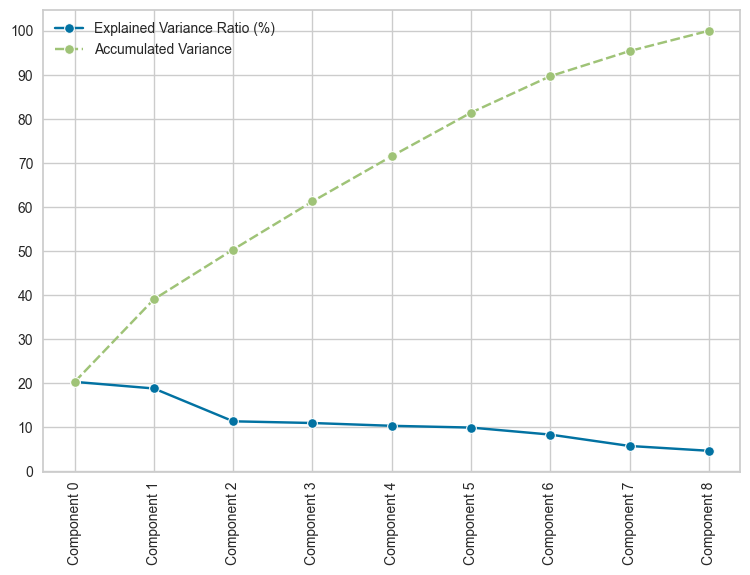

In [199]:
n_components = 9 # initially set to number of columns

def pca_components_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)
    x_PCA = pca.transform(df_pca)  # array with transformed PCA

    ComponentsList = ["Component " + str(number)
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )

    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )

    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_components_analysis(df_pca=df_pca, n_components=n_components)


Based on the PCA explained variance plot, we observe that the first five components together explain approximately 72% of the total variance in the dataset. While adding more components would capture additional variance, the improvement beyond this point becomes marginal. 

Therefore, selecting 5 components provides a good balance between dimensionality reduction and information retention. This choice simplifies the feature space, reduces noise and redundancy, and keeps the clustering model more efficient and interpretable, while still preserving the majority of the data’s underlying structure.

* The 5 components explain 71.52% of the data 



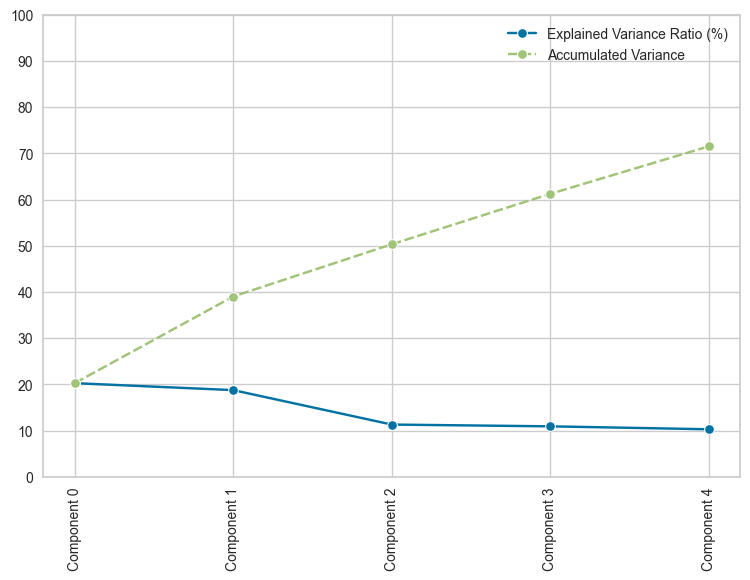

In [292]:
pca_components_analysis(df_pca=df_pca,n_components=5)

Update n_components to 5

In [440]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ('MedianImputer', MeanMedianImputer(imputation_method='median', variables=['person_emp_length', 'loan_int_rate'])),
        ('Winsorizer_iqr', Winsorizer(capping_method='iqr', fold=3, tail='right', variables=numeric_cols)),
        ('log_transform', vt.LogTransformer(variables=['person_age', 
                                                       'person_income', 
                                                       'cb_person_cred_hist_length'])),
        ('power_transform', vt.PowerTransformer(variables=['person_emp_length', 
                                                           'loan_amnt', 
                                                           'loan_percent_income'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=categorical_cols)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        # we update n_components to 5
        ("PCA", PCA(n_components=5, random_state=0)),

        ("model", KMeans(n_clusters=50, random_state=0)),
    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr',
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person_age', '...
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'loan_intent', 'loan_grade',
                                           'cb_person_default_on_file'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=50, random_state=0))])

## Elbow Method and Silhouette Score

Next we determine the optimal number of clusters using:

1. Elbow Method – looks for the point where adding more clusters yields little improvement in compactness.
2. Silhouette Score – measures how well-separated and cohesive the clusters are.

First we transform the dataset up to the PCA step so that it’s scaled and dimensionally reduced, ready for cluster evaluation

In [441]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1]) # drop the KMeans step
df_analysis = pipeline_analysis.fit_transform(df)

print(df_analysis.shape,'\n', type(df_analysis))

(32416, 5) 
 <class 'numpy.ndarray'>


Next, we use the elbow method to identify a suitable number of clusters for our KMeans model. This technique provides a first estimate for the optimal number of clusters.

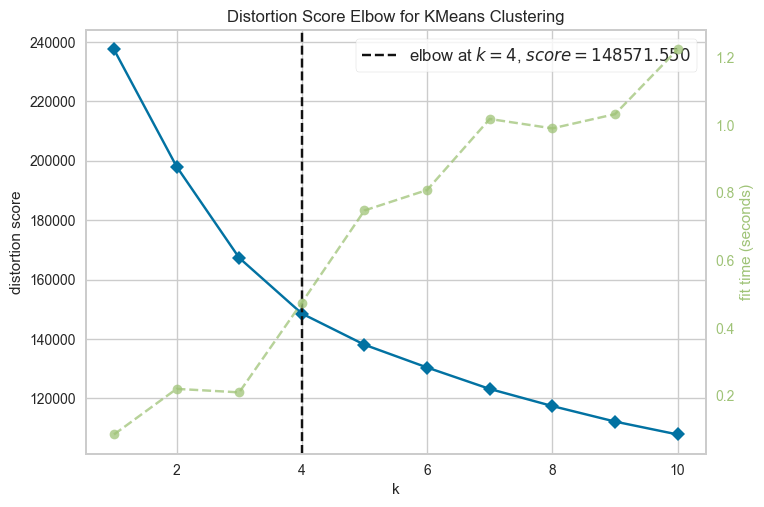

In [277]:
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11)) 
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

* The elbow analysis suggests k=4 as a suitable number of clusters. 

To further validate the choice, we perform silhouette analysis for a range of cluster numbers around the elbow point (k=2–5) to inspect cluster cohesion and separation. We do not consider k=1 because a single cluster would group all data together, providing no meaningful segmentation. 

Once confirmed, we will update the Cluster Pipeline with the chosen number of clusters and refit it to assign cluster labels for further analysis.

=== Average Silhouette Score for different number of clusters ===


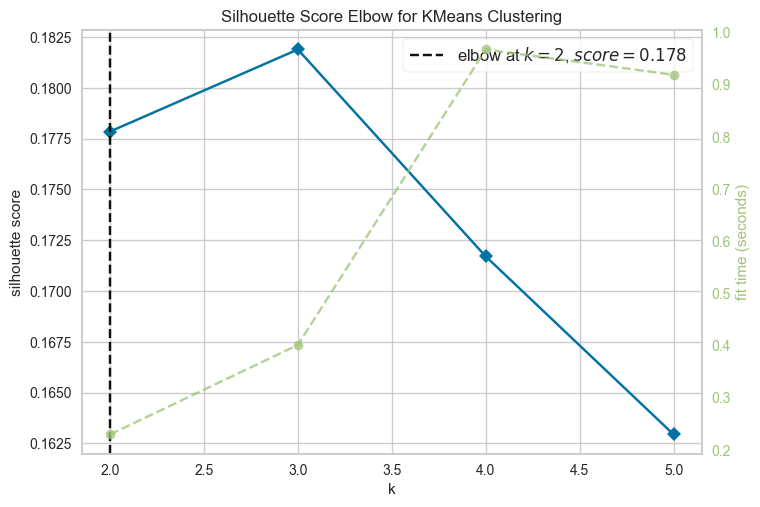



=== Silhouette plot for 2 Clusters ===


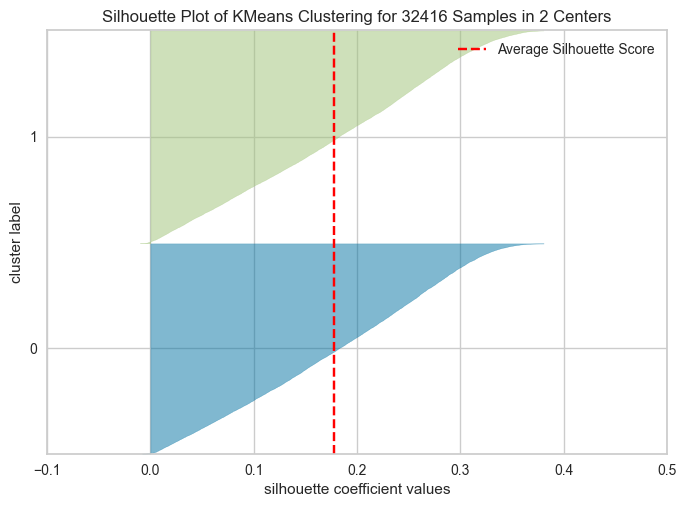



=== Silhouette plot for 3 Clusters ===


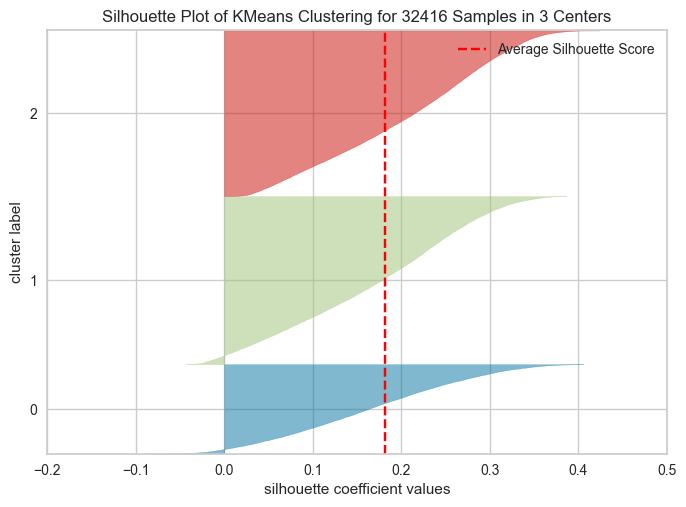



=== Silhouette plot for 4 Clusters ===


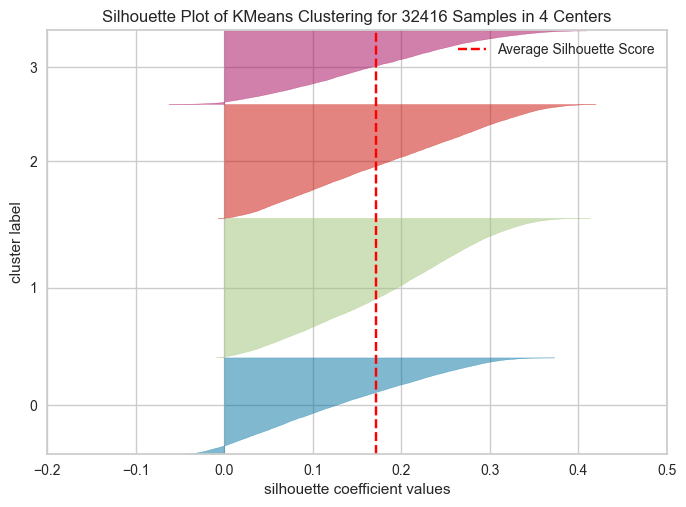



=== Silhouette plot for 5 Clusters ===


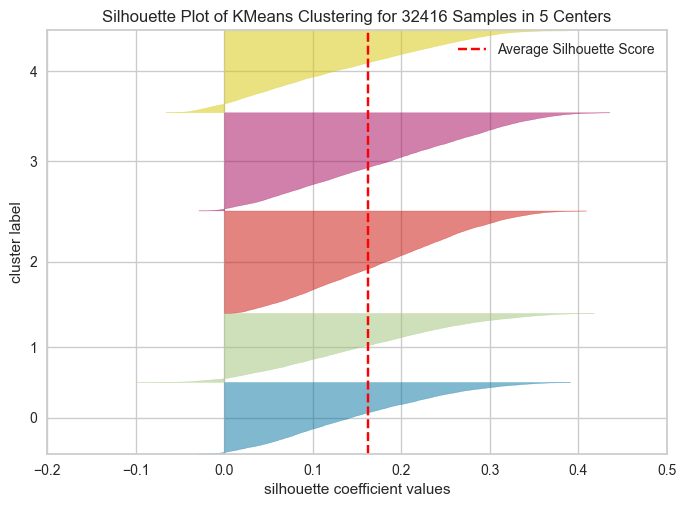

In [295]:
# 6 is not inclusive, it will stop at 5
n_cluster_start, n_cluster_stop = 2, 6

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")

for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")

* The Silhouette Elbow Plot suggests k = 2.
* Therefore we examine the silhouette plots for 2, 3, and 4 clusters (because the elbow method suggested 4 clusters).
* None of the clusters in these plots have silhouette scores below the average.
* The average silhouette score is highest for 3 clusters
* As a result, we select k = 3 as the optimal number of clusters.

Update n_clusters to 3

In [ ]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ('MedianImputer', MeanMedianImputer(imputation_method='median', variables=['person_emp_length', 'loan_int_rate'])),
        ('Winsorizer_iqr', Winsorizer(capping_method='iqr', fold=3, tail='right', variables=numeric_cols)),
        ('log_transform', vt.LogTransformer(variables=['person_age', 
                                                       'person_income', 
                                                       'cb_person_cred_hist_length'])),
        ('power_transform', vt.PowerTransformer(variables=['person_emp_length', 
                                                           'loan_amnt', 
                                                           'loan_percent_income'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=categorical_cols)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),
        
        ("scaler", StandardScaler()),

        ("PCA", PCA(n_components=5, random_state=0)),

        # we update n_clusters to 3
        ("model", KMeans(n_clusters=3, random_state=0)),
    ])
    return pipeline_base


PipelineCluster()


Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr',
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person_age', '...
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'loan_intent', 'loan_grade',
                                           'cb_person_default_on_file'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Fit Cluster Pipeline

Now that we have determined the optimal number of clusters (k = 3) and selected the number of PCA components, we fit the full cluster pipeline to the dataset. This transforms the data, applies scaling, PCA, and generates cluster assignments for each observation, which we can later analyze and profile.

We use the full dataset for clustering since there is no target variable to create a separate test set and evaluate performance on unseen data.

In [471]:
X = df.copy()
print(X.shape)
X.head(3)

(32416, 11)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3


Initialize the clustering pipeline and fit it to the data

In [472]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr',
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person_age', '...
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'loan_intent', 'loan_grade',
                                           'cb_person_default_on_file'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('PCA', PCA(n_components=5, random_state=0)),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Add cluster predictions to dataset

Assign cluster labels from the fitted KMeans model to the original dataframe
* ``pipeline_cluster['model'].labels_`` contains the cluster assignment for each row

In [473]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(5)

(32416, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Clusters
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,0
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,2
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,0
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,0


Now we display the relative frequency of each cluster to understand how the data is distributed across clusters. This gives a sense of which clusters are larger or smaller. Addittionally, we visualize the absolute number of records in each cluster using a bar chart, making it easier to compare cluster sizes at a glance.

* Clusters frequencies 
          proportion
Clusters            
1               0.40
2               0.39
0               0.21 




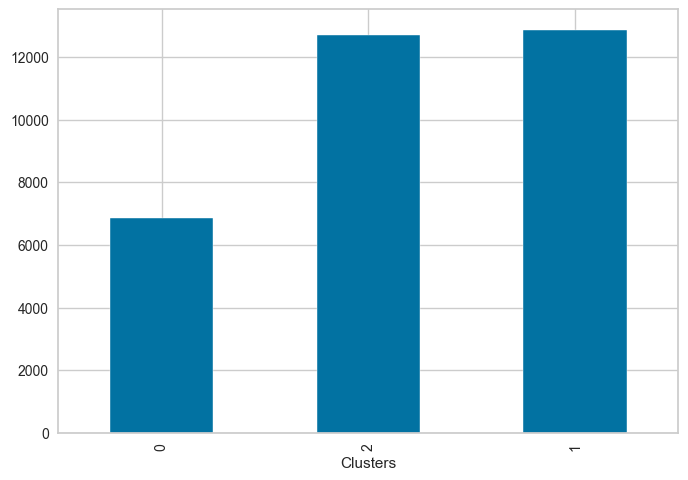

In [474]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

* The analysis shows that the dataset is relatively balanced across the three clusters.
Cluster 1 and Cluster 2 each contain roughly 40% of the records, while Cluster 0 is smaller, representing around 20% of the dataset.
* This distribution still allows for meaningful differentiation between customer segments, while highlighting that Cluster 0 represents a more distinct, less common borrower profile.

Next, we visualize the PCA components and the clusters.

To simplify, we create a 2D scatter plot using the first two PCA components, coloring each point according to its assigned cluster. Additionally, we plot the cluster centroids, which represent the center of each cluster as calculated by the KMeans algorithm.

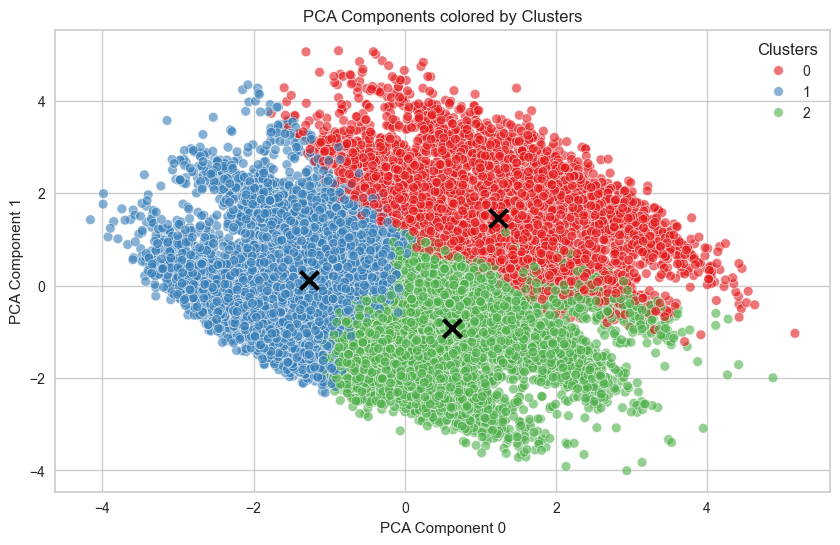

In [447]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_analysis[:, 0], y=df_analysis[:, 1],
                hue=X['Clusters'], palette='Set1', alpha=0.6)
plt.scatter(x=pipeline_cluster['model'].cluster_centers_[:, 0], y=pipeline_cluster['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
plt.xlabel("PCA Component 0")
plt.ylabel("PCA Component 1")
plt.title("PCA Components colored by Clusters")
plt.show()

* Each point represents a borrower and is colored according to its cluster. The PCA components combine multiple original features, so the axes themselves are abstract and don’t have a direct business interpretation.

* In the plot, we can see three distinct clusters, with most points clearly separated. There is some overlap along the cluster borders, but this seems minimal, indicating that the clustering has generally captured meaningful differences between the groups.

We save the cluster predictions from this pipeline to use in the future. We will get back to that in a later stage.

In [475]:
cluster_predictions_with_all_variables = X['Clusters']
cluster_predictions_with_all_variables

0        0
1        2
2        2
3        0
4        0
        ..
32576    1
32577    1
32578    1
32579    1
32580    2
Name: Clusters, Length: 32416, dtype: int32

## Fit a classifier, where the target is cluster predictions and features remaining variables

At this stage, we have assigned each borrower to a cluster, but we have not yet interpreted what each cluster represents.

Next, we will fit a classifier pipeline using the cluster labels as the target variable and the remaining features as inputs. The goal of this approach is to identify which features are most important in defining the clusters. By examining the classifier’s feature importances, we can gain insight into the characteristics that distinguish each group.

We copy `X` to a DataFrame `df_clf`

In [476]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(32416, 12)


,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Clusters
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,0
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,2


Split into Train and Test sets

In [477]:
X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(25932, 11) (6484, 11)


Create classifier pipeline steps

In [478]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        ('MedianImputer', MeanMedianImputer(imputation_method='median', variables=['person_emp_length', 'loan_int_rate'])),
        ('Winsorizer_iqr', Winsorizer(capping_method='iqr', fold=5, tail='right', variables=numeric_cols)),
        ('log_transform', vt.LogTransformer(variables=['person_age', 
                                                       'person_income', 
                                                       'cb_person_cred_hist_length'])),
        ('power_transform', vt.PowerTransformer(variables=['person_emp_length', 
                                                           'loan_amnt', 
                                                           'loan_percent_income'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=categorical_cols)),
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

        ("scaler", StandardScaler()),

        ("feat_selection", SelectFromModel(
            GradientBoostingClassifier(random_state=0))),

        # use an algorithm that typically offers good results, and feature importance
        # can be assessed with .features_importance_
        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=5,
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person...
                                variables=['person_home_ownership',
                                           'loan_intent', 'loan_grade',
                                           'cb_person_default_on_file'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

Fit the classifier to the training data

In [479]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train, y_train)

Pipeline(steps=[('MedianImputer',
                 MeanMedianImputer(variables=['person_emp_length',
                                              'loan_int_rate'])),
                ('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', fold=5,
                            variables=['person_age', 'person_income',
                                       'person_emp_length', 'loan_amnt',
                                       'loan_int_rate', 'loan_percent_income',
                                       'cb_person_cred_hist_length'])),
                ('log_transform',
                 LogTransformer(variables=['person...
                                variables=['person_home_ownership',
                                           'loan_intent', 'loan_grade',
                                           'cb_person_default_on_file'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6)),
                ('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=GradientBoostingClassifier(random_state=0))),
                ('model', GradientBoostingClassifier(random_state=0))])

## Evaluate classifier performance on Train and Test Sets

Our clusters are generally well balanced, so there is no target imbalance to worry about.

If the clusters had been imbalanced, we might have needed to treat the target imbalance before fitting the classifier. In this case, however, we can proceed to fit the model without any special handling.

At this stage of the workflow, we could also conduct a detailed hyperparameter
optimization to find the best model. However, we are only interested in finding a pipeline
that can explain the relationship between the target - Clusters - and the features to assess
the feature importance afterwards. As a result, we will omit this step from the workflow here.

In [453]:
from sklearn.metrics import classification_report
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87      5488
           1       0.84      0.87      0.85     10322
           2       0.82      0.86      0.84     10122

    accuracy                           0.85     25932
   macro avg       0.87      0.84      0.85     25932
weighted avg       0.86      0.85      0.85     25932



In [454]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      1361
           1       0.83      0.86      0.85      2555
           2       0.82      0.86      0.84      2568

    accuracy                           0.85      6484
   macro avg       0.87      0.84      0.85      6484
weighted avg       0.85      0.85      0.85      6484



The classifier performs very well in the train and test set in predicting the cluster labels, achieving an overall accuracy of 85%.

All three clusters are predicted with balanced precision and recall scores, indicating that the model effectively captures the defining characteristics of each segment.
Cluster 0 shows slightly lower recall, suggesting that it is somewhat harder to distinguish compared to the other two clusters, but overall, the classifier demonstrates consistent and reliable performance.
This confirms that the selected features are informative for differentiating between the three borrower profiles.

## Assess the most important Features that define a cluster

After clustering and fitting the classifier pipeline, we want to identify which features are most important in defining the clusters.

* These are the 3 most important features in descending order:
['cb_person_default_on_file', 'person_home_ownership', 'person_income']



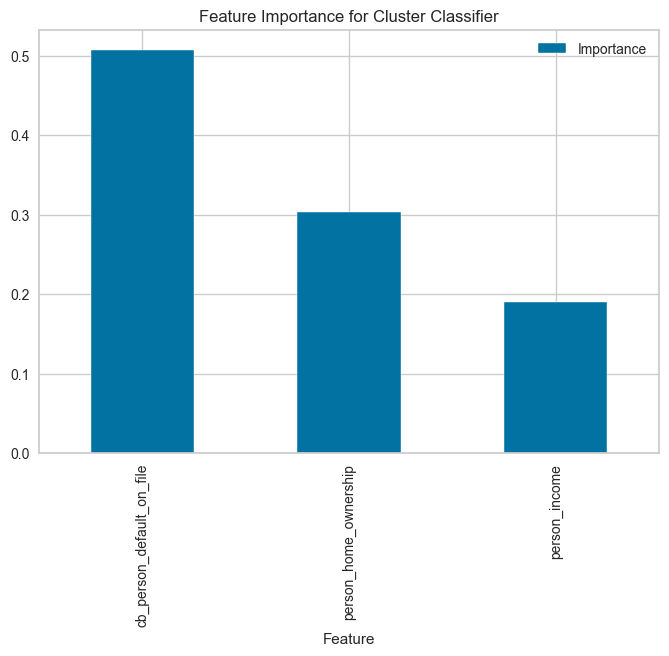

In [480]:
# Extract the feature names after the preprocessing steps but before feature selection
data_cleaning_feat_eng_steps = 6 # Number of preprocessing steps in the pipeline that change the feature space
columns_after_data_cleaning_feat_eng = (
    Pipeline(pipeline_clf_cluster.steps[:data_cleaning_feat_eng_steps])
    .transform(X_train)
    .columns
)

# Select only the features that were retained by the pipeline's feature selection step
best_features = columns_after_data_cleaning_feat_eng[
    pipeline_clf_cluster['feat_selection'].get_support()
].to_list()

# Create a DataFrame showing feature names and their importance according to the trained model
df_feature_importance = pd.DataFrame(
    data={
        'Feature': columns_after_data_cleaning_feat_eng[
            pipeline_clf_cluster['feat_selection'].get_support()
        ],
        'Importance': pipeline_clf_cluster['model'].feature_importances_
    }
).sort_values(by='Importance', ascending=False)  # sort from most to least important

# Update best_features list to reflect the sorted order by importance
best_features = df_feature_importance['Feature'].to_list()

# Print the most important features and how the model was trained on them
print(f"* These are the {len(best_features)} most important features in descending order:\n{best_features}\n")

# Plot the feature importance for visual interpretation
df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importance for Cluster Classifier')
plt.show()


We will store the best_features to use at a later stage.

In [481]:
best_features_pipeline_all_variables = best_features
best_features_pipeline_all_variables

['cb_person_default_on_file', 'person_home_ownership', 'person_income']

'cb_person_default_on_file', 'person_home_ownership' and 'person_income' are the variables that most help to define the clusters.
We can now use these variables to explain each cluster's profile.

## Cluster Analysis

#### Custom Functions

Next, we will set up two custom functions to analyze and describe our clusters:

* DescriptionAllClusters – creates a summary table for each cluster, showing the most common values for categorical variables and the interquartile range (IQR) for numerical variables. This will help us understand the key characteristics of each cluster.

* cluster_distribution_per_variable – visualizes how clusters are distributed across a given variable (e.g., loan_status) and calculates the relative percentage of each target level within clusters. This helps us see patterns and differences between clusters with respect to important outcomes.

We will define these functions now and use them afterwards to explore and interpret the cluster profiles.

1. DescriptionAllClusters()

In [482]:
def DescriptionAllClusters(df, decimal_points=3):

    DescriptionAllClusters = pd.DataFrame(
        columns=df.drop(['Clusters'], axis=1).columns)
    # iterate on each cluster , calls Clusters_IndividualDescription()
    for cluster in df.sort_values(by='Clusters')['Clusters'].unique():

        EDA_ClusterSubset = df.query(
            f"Clusters == {cluster}").drop(['Clusters'], axis=1)
        ClusterDescription = Clusters_IndividualDescription(
            EDA_ClusterSubset, cluster, decimal_points)
        DescriptionAllClusters = pd.concat(
            [ClusterDescription, DescriptionAllClusters])

    DescriptionAllClusters.set_index(['Cluster'], inplace=True)
    return DescriptionAllClusters


def Clusters_IndividualDescription(EDA_Cluster, cluster, decimal_points):

    ClustersDescription = pd.DataFrame(columns=EDA_Cluster.columns)
    # for a given cluster, iterate over all columns
    # if the variable is numerical, calculate the IQR: display as Q1 -- Q3.
    # That will show the range for the most common values for the numerical variable
    # if the variable is categorical, count the frequencies and displays the top 3 most frequent
    # That will show the most common levels for the category

    for col in EDA_Cluster.columns:

        try:  # eventually a given cluster will have only missing data for a given variable

            if EDA_Cluster[col].dtypes == 'object':

                top_frequencies = EDA_Cluster.dropna(
                    subset=[col])[[col]].value_counts(normalize=True).nlargest(n=3)
                Description = ''

                for x in range(len(top_frequencies)):
                    freq = top_frequencies.iloc[x]
                    category = top_frequencies.index[x][0]
                    CategoryPercentage = int(round(freq*100, 0))
                    statement = f"'{category}': {CategoryPercentage}% , "
                    Description = Description + statement

                ClustersDescription.at[0, col] = Description[:-2]

            elif EDA_Cluster[col].dtypes in ['float64', 'int64']:
                DescStats = EDA_Cluster.dropna(subset=[col])[[col]].describe()
                Q1 = round(DescStats.loc['25%', col], decimal_points)
                Q3 = round(DescStats.loc['75%', col], decimal_points)
                Description = f"{Q1} -- {Q3}"
                ClustersDescription.at[0, col] = Description

        except Exception as e:
            ClustersDescription.at[0, col] = 'Not available'
            print(
                f"** Error Exception: {e} - cluster {cluster}, variable {col}")

    ClustersDescription['Cluster'] = str(cluster)

    return ClustersDescription


2. cluster_distribution_per_variable()

In [ ]:
def cluster_distribution_per_variable(df, target):
    """
    The data should have 2 variables, the cluster predictions and
    the variable you want to analyze with, in this case we call "target".
    We use plotly express to create 2 plots:
    Cluster distribution across the target.
    Relative presence of the target level in each cluster.
    """
    df_bar_plot = df.groupby(['Clusters', target]).size().reset_index(name='Count')
    df_bar_plot.columns = ['Clusters', target, 'Count']
    df_bar_plot[target] = df_bar_plot[target].astype('object')

    print(f"Clusters distribution across {target} levels")
    fig = px.bar(df_bar_plot, x='Clusters', y='Count',
                 color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.show(renderer='jupyterlab')

    df_relative = (df
                   .groupby(["Clusters", target])
                   .size()
                   .unstack(fill_value=0)
                   .apply(lambda x: 100 * x / x.sum(), axis=1)
                   .stack()
                   .reset_index(name='Relative Percentage (%)')
                   .sort_values(by=['Clusters', target])
                   )

    print(f"Relative Percentage (%) of {target} in each cluster")
    fig = px.line(df_relative, x='Clusters', y='Relative Percentage (%)',
                  color=target, width=800, height=500)
    fig.update_layout(xaxis=dict(tickmode='array',
                      tickvals=df['Clusters'].unique()))
    fig.update_traces(mode='markers+lines')
    fig.show(renderer='jupyterlab')

### Cluster profile based on the best features

#### Prepare data

Before using the ``DescriptionAllClusters`` function, we prepare the data as follows:

1. Select relevant features – We create ``df_cluster_profile`` from our classifier dataset, keeping only the best features (as determined from feature importance) and the cluster labels. This ensures that the description focuses on the most relevant variables.

In [483]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
print(df_cluster_profile.shape)
df_cluster_profile.head(3)

(32416, 4)


,cb_person_default_on_file,person_home_ownership,person_income,Clusters
0,Y,RENT,59000,0
1,N,OWN,9600,2
2,N,MORTGAGE,9600,2


2. Prepare the target variable – We load the default data (df_default), drop duplicates, and keep only the target variable. Since it is encoded as an integer but represents a categorical outcome, we convert it to type object.

In [484]:
df_default = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")
# Default is encoded as an integer,
# even being a categorical variable. Therefore for this analysis we'll change its data type to 'object'.
# for cluster analysis plot (!)
df_default = df_default.drop_duplicates().filter([target_var])
# df_default = df_default
print(df_default.shape)
df_default[target_var] = df_default[target_var].astype('object')
df_default.head(3)

(32416, 1)


,loan_status
0,1
1,0
2,1


3. Combine features and target

In [485]:
df_combined = pd.concat([
    df_cluster_profile.reset_index(drop=True),
    df_default.reset_index(drop=True)
], axis=1)

#### Generate cluster description

In [486]:
pd.set_option('display.max_colwidth', None)

clusters_profile = DescriptionAllClusters(df=df_combined, decimal_points=0)
clusters_profile

,cb_person_default_on_file,person_home_ownership,person_income,loan_status
Cluster,,,,
2,"'N': 98% , 'Y': 2%","'RENT': 81% , 'MORTGAGE': 10% , 'OWN': 9%",30000.0 -- 55000.0,"'0': 76% , '1': 24%"
1,"'N': 99% , 'Y': 1%","'MORTGAGE': 75% , 'RENT': 17% , 'OWN': 7%",55782.0 -- 100000.0,"'0': 91% , '1': 9%"
0,"'Y': 79% , 'N': 21%","'RENT': 57% , 'MORTGAGE': 35% , 'OWN': 8%",38400.0 -- 77000.0,"'0': 59% , '1': 41%"


Cluster Description using the most important features:

* Cluster 0: Borrowers with a history of previous defaults: mostly renters, with moderate incomes and the highest default rate (41%). This group represents a higher-risk segment.
* Cluster 1: Borrowers who primarily have mortgages, earn higher incomes, and rarely default (only 9%). This is the most financially stable and lowest-risk group.
* Cluster 2: Borrowers who mostly rent, have lower to mid-range incomes, and moderate default rates (24%). They generally have no prior default record but represent a middle-risk segment between Clusters 0 and 1.

### Clusters distribution across Default levels & Relative Percentage of Default in each cluster

Next, we want to analyze how the clusters relate to loan defaults.
We create a new DataFrame containing the predicted cluster for each user and their default status. Using cluster_distribution_per_variable, we will visualize:

* The absolute distribution of clusters colored by default level.
* The relative percentage of default levels within each cluster.

This helps us understand which clusters are more prone to default and provides actionable insights for risk management.

In [487]:
df_cluster_vs_Default=  df_default.copy()
df_cluster_vs_Default['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_Default, target=target_var)

Clusters distribution across loan_status levels


Relative Percentage (%) of loan_status in each cluster


* In summary, we can see that borrowers in Cluster 0 tend to default the most (41%), followed by Cluster 2 with a moderate default rate (24%). Cluster 1 borrowers are the most stable, with only 9% defaulting.

**Business interpretation:**  
To mitigate default risk, borrowers in Cluster 0 should receive closer monitoring, stricter underwriting, or smaller loan approvals. Cluster 2 borrowers may qualify for standard terms but could benefit from proactive financial counseling or tighter credit limits. Cluster 1 borrowers, being the most reliable, can be prioritized for favorable loan conditions or loyalty-based incentives.

# Fit New Cluster Pipeline with most important features

To simplify the cluster pipeline and reduce the number of variables, we will compare the original cluster pipeline (using all features) with a new pipeline that uses only the variables identified as most important for defining the clusters.

In [488]:
best_features_pipeline_all_variables

['cb_person_default_on_file', 'person_home_ownership', 'person_income']

## Define trade-off and metrics to compare new and previous Cluster Pipeline

The evaluation will follow these steps:

1. Apply the elbow method and silhouette analysis to see if the same number of clusters is suggested.
2. Fit the new cluster pipeline and compare its predictions to the previous pipeline to check for consistency.
3. Fit a classifier to explain the clusters and compare Train/Test performance to the original pipeline.
4. Verify if the classifier identifies the same most important features as before.
5. Compare the cluster profiles from both pipelines to check if they are equivalent.

If the new pipeline passes these checks, it can be used in production to predict clusters for prospects using fewer variables, which is particularly beneficial for real-time applications.

If not all criteria are met, it becomes a contextual decision: stakeholders must decide if they accept the trade-offs and interpretations of the new pipeline. There is no strict right or wrong in this case.

## Subset data with the most relevant variables

In [538]:
df_reduced = df.filter(best_features_pipeline_all_variables)
df_reduced.head(3)

,cb_person_default_on_file,person_home_ownership,person_income
0,Y,RENT,59000
1,N,OWN,9600
2,N,MORTGAGE,9600


## Rewrite Cluster Pipeline

In [539]:
def PipelineCluster():
    pipeline_base = Pipeline([
        ('Winsorizer_iqr', Winsorizer(capping_method='iqr', fold=3, tail='right', variables=['person_income'])),
        ('log_transform', vt.LogTransformer(variables=['person_income'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["person_home_ownership", "cb_person_default_on_file"])),
        
        # it doesn't need SmartCorrelation
        
        ("scaler", StandardScaler()),
        
        # No PCA step needed, since we know which features to consider

        ("model", KMeans(n_clusters=3, random_state=0))

    ])
    return pipeline_base



PipelineCluster()

Pipeline(steps=[('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', variables=['person_income'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'cb_person_default_on_file'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Apply Elbow Method and Silhouette analysis

In [540]:
pipeline_cluster = PipelineCluster()
pipeline_analysis = Pipeline(pipeline_cluster.steps[:-1])
df_analysis = pipeline_analysis.fit_transform(df_reduced)

print(df_analysis.shape,'\n', type(df_analysis))

(32416, 3) 
 <class 'numpy.ndarray'>


Elbow Analysis

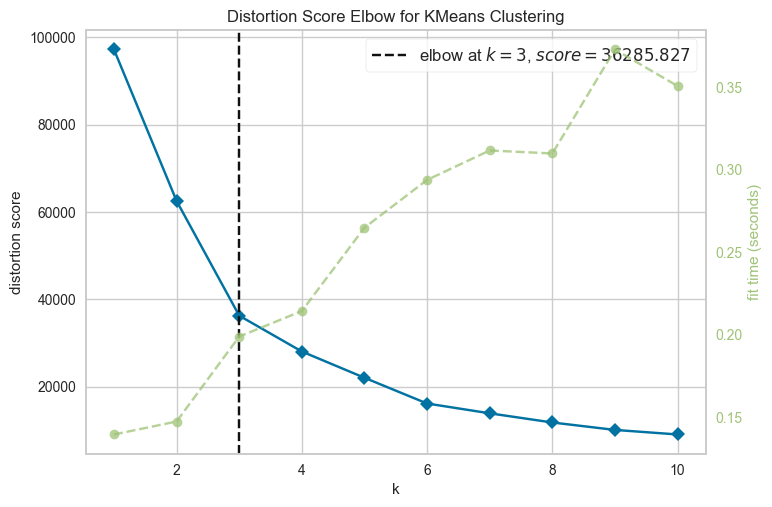

In [541]:
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(1,11))
visualizer.fit(df_analysis) 
visualizer.show() 
plt.show()

 We note that this plot suggests 4 clusters
and that a sharp fall happens between 2 and 4, so we can pick this range for Silhouette analysis.

=== Average Silhouette Score for different number of clusters ===


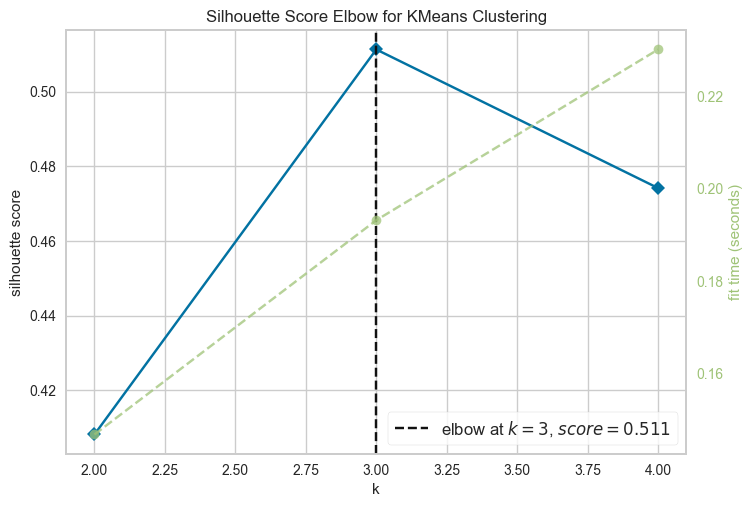



=== Silhouette plot for 2 Clusters ===


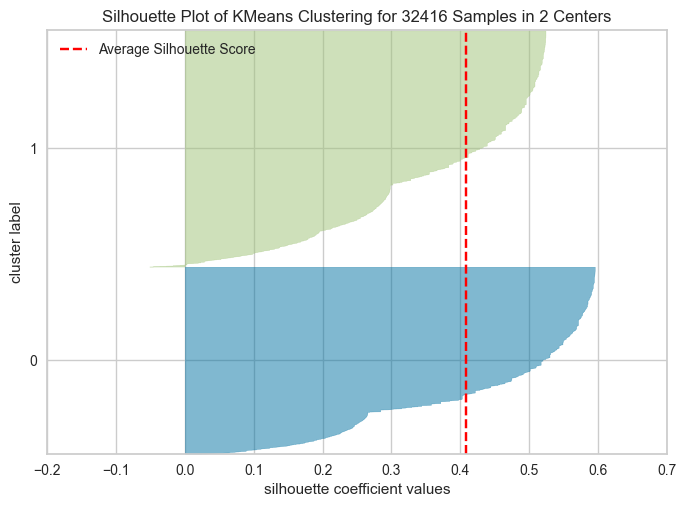



=== Silhouette plot for 3 Clusters ===


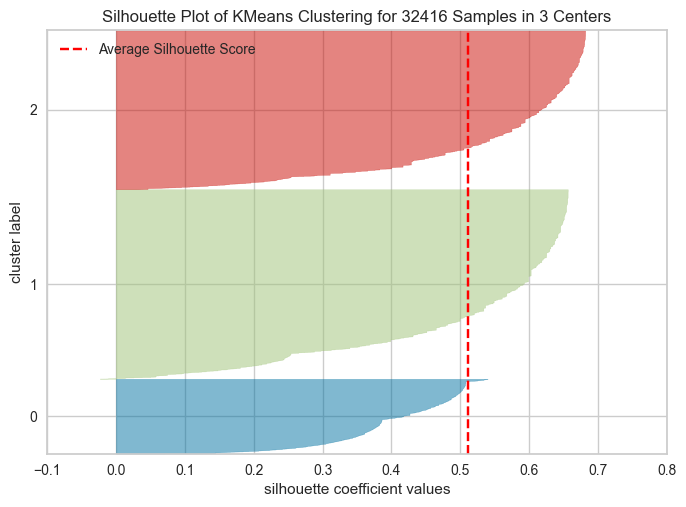



=== Silhouette plot for 4 Clusters ===


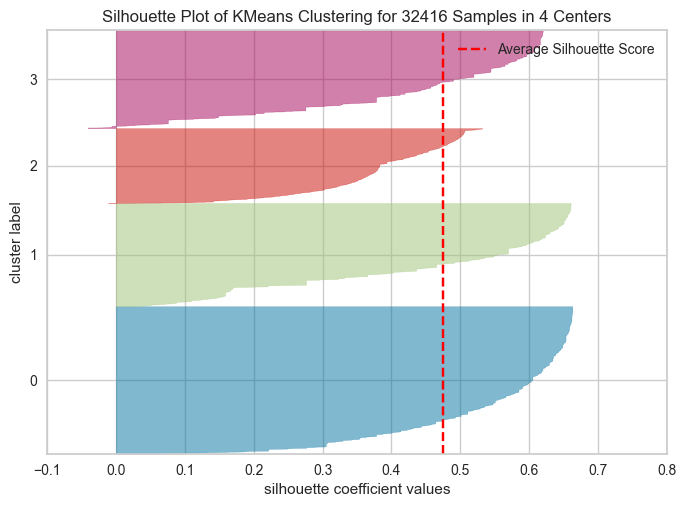

In [542]:
n_cluster_start, n_cluster_stop = 2, 5

print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=0), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters, random_state=0),
                                      colors='yellowbrick')
    visualizer.fit(df_analysis)
    visualizer.show()
    plt.show()
    print("\n")


* The Silhouette Elbow Plot suggests k = 3

* The silhouette plots confirm this choice: the three-cluster solution shows the highest average silhouette score, no negative silhouette values, and both clusters exceed the average score. Therefore, we select k = 3 as the optimal number of clusters for this dataset.

## Fit New Cluster Pipeline

We set X as our training set for the cluster. It is a copy of df_reduced

In [495]:
X = df_reduced.copy()
print(X.shape)
X.head(3)

(32416, 3)


,cb_person_default_on_file,person_home_ownership,person_income
0,Y,RENT,59000
1,N,OWN,9600
2,N,MORTGAGE,9600


Fit Cluster pipeline

In [496]:
pipeline_cluster = PipelineCluster()
pipeline_cluster.fit(X)

Pipeline(steps=[('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', variables=['person_income'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'cb_person_default_on_file'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

## Add cluster predictions to dataset

We add a column "`Clusters`" (with the cluster pipeline predictions) to the dataset

In [497]:
X['Clusters'] = pipeline_cluster['model'].labels_
print(X.shape)
X.head(3)

(32416, 4)


,cb_person_default_on_file,person_home_ownership,person_income,Clusters
0,Y,RENT,59000,0
1,N,OWN,9600,1
2,N,MORTGAGE,9600,1


* Clusters frequencies 
          proportion
Clusters            
1               0.45
2               0.38
0               0.18 




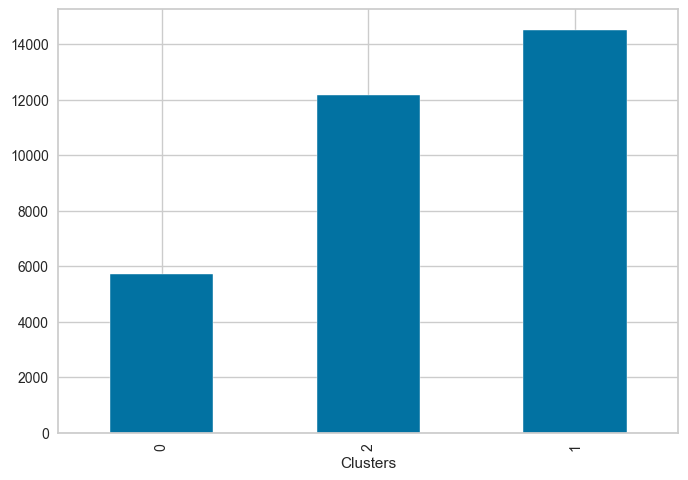

In [498]:
print(f"* Clusters frequencies \n{ X['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
X['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

The cluster distribution shows that Cluster 1 now represents the largest share with 45% of the data, followed by Cluster 2 with 38%, and Cluster 0 with 18%.
Compared to the previous, more balanced distribution, the new model produces a slightly more uneven split, indicating that borrowers in Cluster 1 are somewhat more prevalent in the dataset.

As the difference to the previous model is not too large, we consider it to be okay. But how similar are the predictions from this cluster
and the previous cluster?

## Compare current cluster predictions to previous cluster predictions

We just fitted a new cluster pipeline and want to compare if its predictions are "equivalent" to the previous cluster.

These are the predictions from the **previous** cluster pipeline - trained with all variables 

In [499]:
cluster_predictions_with_all_variables

0        0
1        2
2        2
3        0
4        0
        ..
32576    1
32577    1
32578    1
32579    1
32580    2
Name: Clusters, Length: 32416, dtype: int32

And these are the predictions from the **current** cluster pipeline (trained with `['cb_person_default_on_file', 'person_home_ownership', 'person_income']`)

In the following analysis steps, it becomes apparent that the cluster labels between the predictions using all variables and those using only the best features are inverted for cluster 1 and 2. To ensure both predictions are comparable, we reassign the labels in the reduced-feature predictions accordingly.

In [ ]:
cluster_predictions_with_best_features = X['Clusters'].replace({1: 99, 2: 1}).replace({99: 2})
cluster_predictions_with_best_features

0        0
1        2
2        2
3        2
4        0
        ..
32576    1
32577    1
32578    2
32579    1
32580    2
Name: Clusters, Length: 32416, dtype: int32

We use a confusion matrix to evaluate if the predictions of both pipelines are **"equivalent"**

In [516]:
print(confusion_matrix(cluster_predictions_with_all_variables, cluster_predictions_with_best_features))

[[ 5438   522   889]
 [   90 10265  2522]
 [  202  1381 11107]]


The confusion matrix shows a strong agreement between the two clustering pipelines (the original one and the reduced-feature one):

* The majority of records are consistently assigned to the same cluster
* Only a relatively small number of records are assigned differently across the two pipelines, indicating minor discrepancies

Conclusion:

* The two pipelines produce very similar cluster assignments, meaning the reduced-feature pipeline (using only the most important variables) effectively captures the same structure in the data.
This makes it a solid candidate for deployment, it’s simpler, faster, and nearly as accurate as the full version.

## Fit a classifier, where the target is cluster predictions and features remaining variables

We are again in a position where we can fit a cluster pipeline but we will first need
clarification on the most relevant features for the clusters. We will use a classifier
pipeline to help in this task using the supervised learning workflow that we're already familiar with.

In [517]:
df_clf = X.copy()
print(df_clf.shape)
df_clf.head(3)

(32416, 4)


,cb_person_default_on_file,person_home_ownership,person_income,Clusters
0,Y,RENT,59000,0
1,N,OWN,9600,1
2,N,MORTGAGE,9600,1


Split into Train and Test sets

In [518]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df_clf.drop(['Clusters'], axis=1),
    df_clf['Clusters'],
    test_size=0.2,
    random_state=0
)

print(X_train.shape, X_test.shape)


(25932, 3) (6484, 3)


Rewrite pipeline to explain clusters

In [ ]:
def PipelineClf2ExplainClusters():
    pipeline_base = Pipeline([
        ('Winsorizer_iqr', Winsorizer(capping_method='iqr', fold=3, tail='right', variables=['person_income'])),
        ('log_transform', vt.LogTransformer(variables=['person_income'])),
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=["person_home_ownership", "cb_person_default_on_file"])),
        
        # it doesn't need SmartCorrelation

        ("scaler", StandardScaler()),

        # we don't consider feature selection step, since we know which features to consider

        ("model", GradientBoostingClassifier(random_state=0)),

    ])
    return pipeline_base


PipelineClf2ExplainClusters()


Pipeline(steps=[('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', variables=['person_income'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'cb_person_default_on_file'])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

## Fit a classifier, where the target is cluster labels and features remaining variables

Create and fit a classifier pipeline to learn the feature importance when defining a cluster

In [520]:
pipeline_clf_cluster = PipelineClf2ExplainClusters()
pipeline_clf_cluster.fit(X_train,y_train)

Pipeline(steps=[('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', variables=['person_income'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'cb_person_default_on_file'])),
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(random_state=0))])

## Evaluate classifier performance on Train and Test Sets

In [506]:
print(classification_report(y_train, pipeline_clf_cluster.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4600
           1       1.00      1.00      1.00     11584
           2       1.00      1.00      1.00      9748

    accuracy                           1.00     25932
   macro avg       1.00      1.00      1.00     25932
weighted avg       1.00      1.00      1.00     25932



In [507]:
print(classification_report(y_test, pipeline_clf_cluster.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1130
           1       1.00      1.00      1.00      2934
           2       1.00      1.00      1.00      2420

    accuracy                           1.00      6484
   macro avg       1.00      1.00      1.00      6484
weighted avg       1.00      1.00      1.00      6484



The classifier shows good performance in both the train and the test set

## Assess Most Important Features

The best features are now the columns of our train set

* These are the 3 most important features in descending order. The model was trained on them: 
['person_home_ownership', 'cb_person_default_on_file', 'person_income']


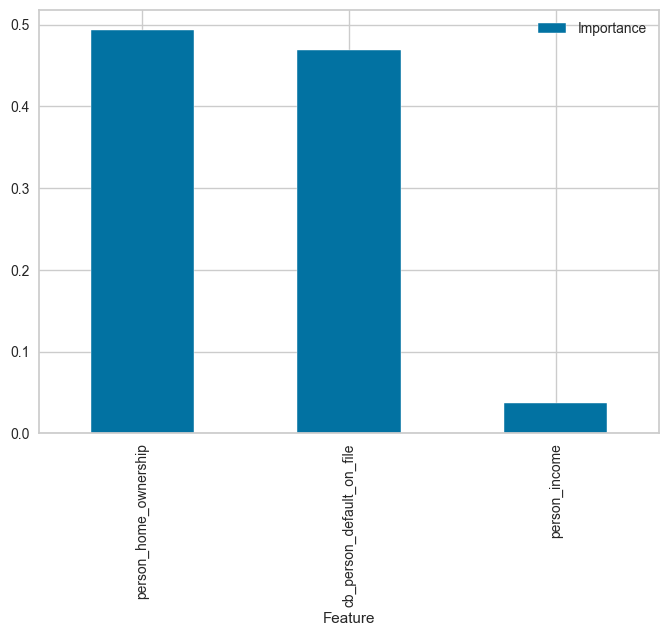

In [521]:
best_features = X_train.columns.to_list()

# create a DataFrame to display feature importance
df_feature_importance = (pd.DataFrame(data={
    'Feature': best_features,
    'Importance': pipeline_clf_cluster['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance['Feature'].to_list()

# Most important features statement and plot
print(f"* These are the {len(best_features)} most important features in descending order. "
      f"The model was trained on them: \n{df_feature_importance['Feature'].to_list()}")

df_feature_importance.plot(kind='bar', x='Feature', y='Importance')
plt.show()


In the initial model, cluster formation was influenced by a more balanced mix of factors: default on file (50%), home ownership (30%), and income (20%).
In the reduced model, home ownership and default on file now dominate equally with around 50% each, while income contributes only about 5%.

This indicates that the simplified model primarily separates borrowers based on whether they have a history of default and their home ownership status. It effectively captures the main drivers of segmentation but loses some of the nuanced influence of income.

While the reduced model is more efficient and suitable for real-time applications, it provides a narrower perspective on borrower behavior.

Therefore, in a real-world scenario, stakeholders should evaluate whether this trade-off between simplicity and interpretability is acceptable. If the reduced model still meets business objectives, it can be preferred for operational use; otherwise, retaining the full model may be more valuable for deeper insights and decision-making.

However, for the purpose of this project’s learning objective, we accept the less balanced mix of influencing factors, as it demonstrates the trade-offs involved when simplifying models for practical use.


## Cluster Analysis

Create a DataFrame that contains the best features and Clusters Predictions: we want to analyse the patterns for each cluster.


In [522]:
df_cluster_profile = df_clf.copy()
df_cluster_profile = df_cluster_profile.filter(items=best_features + ['Clusters'], axis=1)
df_cluster_profile.head(3)

,person_home_ownership,cb_person_default_on_file,person_income,Clusters
0,RENT,Y,59000,0
1,OWN,N,9600,1
2,MORTGAGE,N,9600,1


We want also to analyse Default levels

In [523]:
df_default = pd.read_csv("outputs/datasets/collection/LoanDefaultData.csv")
df_default = df_default.drop_duplicates().filter([target_var])
print(df_default.shape)
df_default[target_var] = df_default[target_var].astype('object')
df_default.head(3)


(32416, 1)


,loan_status
0,1
1,0
2,1


### Cluster profile on most important features

In [524]:
pd.set_option('display.max_colwidth', None)
clusters_profile = DescriptionAllClusters(df= pd.concat([df_cluster_profile,df_default], axis=1), decimal_points=0)
clusters_profile

,person_home_ownership,cb_person_default_on_file,person_income,loan_status
Cluster,,,,
2,"'MORTGAGE': 93% , 'OWN': 6% , 'OTHER': 1%",'N': 100%,50400.0 -- 96000.0,"'0': 91% , '1': 9%"
1,"'RENT': 90% , 'OWN': 10% , 'MORTGAGE': 0%",'N': 100%,33000.0 -- 64144.0,"'0': 74% , '1': 26%"
0,"'RENT': 57% , 'MORTGAGE': 35% , 'OWN': 8%",'Y': 100%,36000.0 -- 78000.0,"'0': 62% , '1': 38%"


Cluster Description using the most important features:

* Cluster 0: Borrowers with a history of previous defaults: mostly renters, with moderate incomes and the highest default rate. This group represents a higher-risk segment.
* Cluster 1: Borrowers who mostly rent, have lower to mid-range incomes, and moderate default rates. They generally have no prior default record but represent a middle-risk segment.
* Cluster 2: Borrowers who primarily have mortgages, earn higher incomes, and rarely default. This is the most financially stable and lowest-risk group.

>Note: Compared to the earlier analysis, the labels for cluster 1 and 2 appear reversed, but the underlying groups and interpretations remain consistent.

### Clusters distribution across Default levels & Relative Percentage of Default in each cluster

In [525]:
df_cluster_vs_Default=  df_default.copy()
df_cluster_vs_Default['Clusters'] = X['Clusters']
cluster_distribution_per_variable(df=df_cluster_vs_Default, target=target_var)

Clusters distribution across loan_status levels


Relative Percentage (%) of loan_status in each cluster


There are only minor
differences in the cluster profile. However, that is not significant and overall we can achieve the
same interpretations from the previous pipeline. In relation to the cluster distribution
across Default levels, there is no change between this and the previous pipeline.

## Which pipeline should I deploy?

Let's recap the criteria we consider to evaluate the **trade-off**
1. Apply the elbow method and silhouette analysis to see if the same number of clusters is suggested.
    * The elbow and silhouette analysis both suggested k=3
2. Fit the new cluster pipeline and compare its predictions to the previous pipeline to check for consistency.
    * The confusion matrix showed the clusters were largely equivalent after relabeling
3. Fit a classifier to explain the clusters and compare Train/Test performance to the original pipeline.
4. Verify if the classifier identifies the same most important features as before.
    * The classifier performance and interpretability were similar
5. Compare the cluster profiles from both pipelines to check if they are equivalent.
    * The cluster profiles were consistent (though with reversed labels and less dominance of income)

In [526]:
pipeline_cluster

Pipeline(steps=[('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', variables=['person_income'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'cb_person_default_on_file'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

We considered 5 criteria to evaluate the trade-off when fitting the new pipeline using only the most important features.
In this case, all five criteria were satisfactorily met. The elbow method and silhouette analysis both suggested k=3 clusters, the same as the previous pipeline. After relabeling, the cluster predictions were largely equivalent, and the classifier performance on the Train and Test sets remained consistent.

Although the feature importance became more concentrated in home ownership and default on file compared to the previous model, the overall cluster profiles and their interpretations remained aligned with earlier findings (with reversed label assignments).

Therefore, we can confidently select the reduced-feature pipeline, as it achieves comparable clustering quality while simplifying the model and reducing the number of variables needed for real-time applications.

# Push files to Repo


We will generate the following files

* Cluster Pipeline
* Train Set
* Feature importance plot
* Clusters Description
* Cluster Silhouette


In [527]:
version = 'v2'
file_path = f'outputs/ml_pipeline/cluster_analysis/{version}'

try:
    os.makedirs(name=file_path)
except Exception as e:
    print(e)

## Cluster pipeline

In [528]:
pipeline_cluster

Pipeline(steps=[('Winsorizer_iqr',
                 Winsorizer(capping_method='iqr', variables=['person_income'])),
                ('log_transform', LogTransformer(variables=['person_income'])),
                ('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['person_home_ownership',
                                           'cb_person_default_on_file'])),
                ('scaler', StandardScaler()),
                ('model', KMeans(n_clusters=3, random_state=0))])

In [529]:
joblib.dump(value=pipeline_cluster, filename=f"{file_path}/cluster_pipeline.pkl")

['outputs/ml_pipeline/cluster_analysis/v2/cluster_pipeline.pkl']

## Train Set

In [530]:
print(df_reduced.shape)
df_reduced.head(3)

(32416, 3)


,cb_person_default_on_file,person_home_ownership,person_income
0,Y,RENT,59000
1,N,OWN,9600
2,N,MORTGAGE,9600


In [531]:
df_reduced.to_csv(f"{file_path}/TrainSet.csv", index=False)

## Most important features plot

These are the features that define a cluster

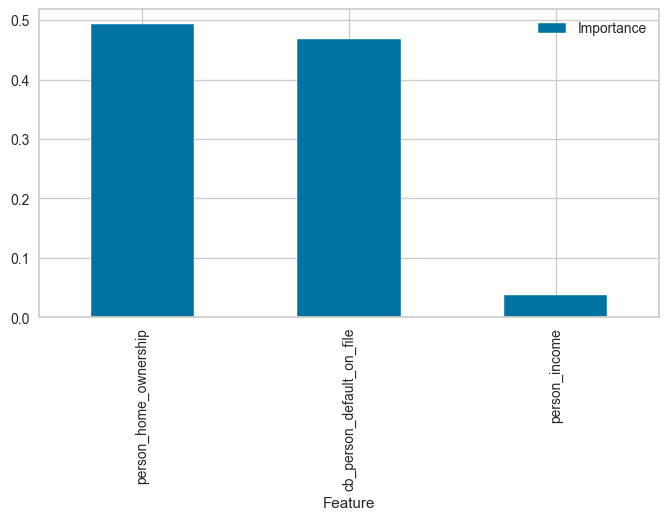

In [532]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.show()

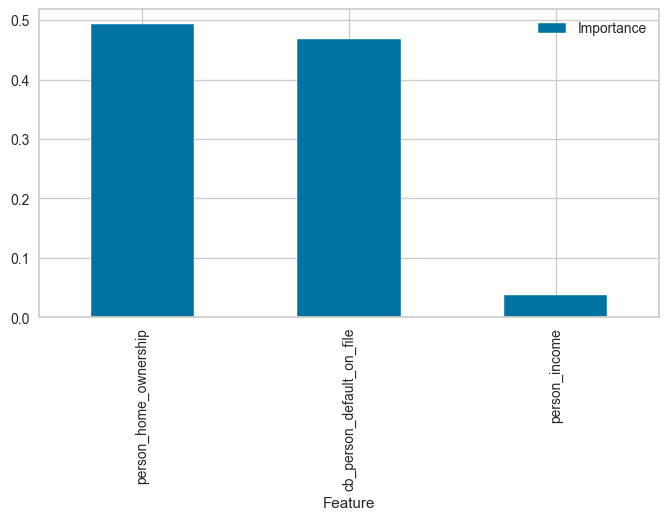

In [533]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance', figsize=(8,4))
plt.savefig(f"{file_path}/features_define_cluster.png", bbox_inches='tight', dpi=150)

## Cluster Profile

In [534]:
clusters_profile

,person_home_ownership,cb_person_default_on_file,person_income,loan_status
Cluster,,,,
2,"'MORTGAGE': 93% , 'OWN': 6% , 'OTHER': 1%",'N': 100%,50400.0 -- 96000.0,"'0': 91% , '1': 9%"
1,"'RENT': 90% , 'OWN': 10% , 'MORTGAGE': 0%",'N': 100%,33000.0 -- 64144.0,"'0': 74% , '1': 26%"
0,"'RENT': 57% , 'MORTGAGE': 35% , 'OWN': 8%",'Y': 100%,36000.0 -- 78000.0,"'0': 62% , '1': 38%"


In [535]:
clusters_profile.to_csv(f"{file_path}/clusters_profile.csv")

## Cluster silhouette plot

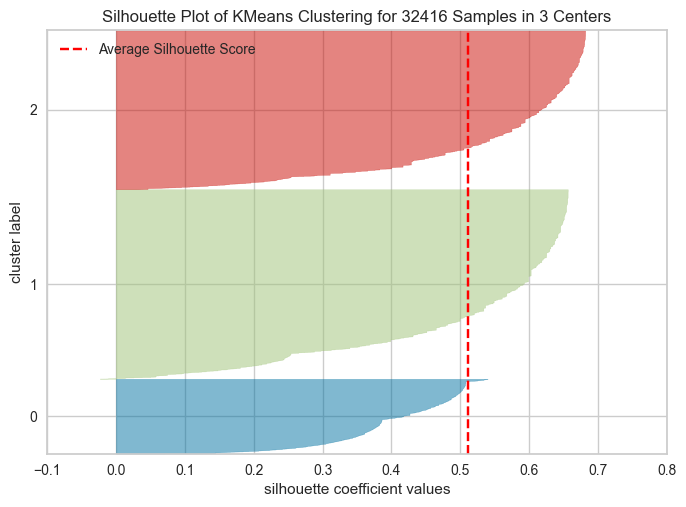

In [536]:
visualizer = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick')
visualizer.fit(df_analysis)
visualizer.show()
plt.show()

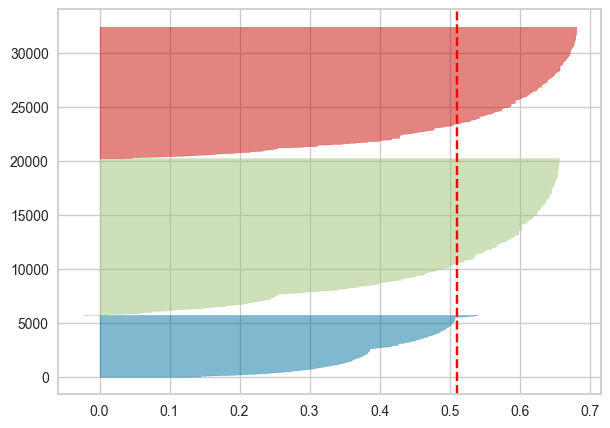

In [537]:
fig, axes = plt.subplots(figsize=(7,5))
fig = SilhouetteVisualizer(Pipeline(pipeline_cluster.steps[-1:])[0] , colors='yellowbrick', ax=axes)
fig.fit(df_analysis)

plt.savefig(f"{file_path}/clusters_silhouette.png", bbox_inches='tight',dpi=150)

---

# Conclusions

We applied a clustering pipeline to segment loan applicants based on key features. After preprocessing, dimensionality reduction with PCA, and KMeans clustering, we identified three main clusters:
* Cluster 0: Borrowers with a history of previous defaults: mostly renters, with moderate incomes and the highest default rate. This group represents a higher-risk segment.
* Cluster 1: Borrowers who mostly rent, have lower to mid-range incomes, and moderate default rates. They generally have no prior default record but represent a middle-risk segment.
* Cluster 2: Borrowers who primarily have mortgages, earn higher incomes, and rarely default. This is the most financially stable and lowest-risk group.

A classifier confirmed that the most important features defining the clusters are person_home_ownership and cb_person_default_on_file, with person_income playing a much smaller role. The final cluster model using only these features is robust, interpretable, and will be applied in the dashboard alongside our predictive default model. This allows us to segment borrowers and provide actionable insights in real time.